In [ ]:
import json
import os
import random
from tqdm import tqdm
from datasets import load_from_disk, Dataset
import numpy as np
import torch
from transformers import VisionEncoderDecoderModel, AutoImageProcessor, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback


In [ ]:
# !pip install datasets

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = "facebook/timesformer-base-finetuned-k600"
decoder = "gpt2"

In [ ]:
device

device(type='cuda')

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
tokenizer = AutoTokenizer.from_pretrained(decoder)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder, decoder).to(device)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.max_length = 50
model.config.num_beams = 4
model.config.early_stopping = True

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', '

In [ ]:

dataset = load_from_disk("/content/drive/MyDrive/dataset/processed_movie_clips")
dataset.set_format("torch")

In [ ]:

class ProcessedMovieClipsDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        return {
            "videoID": example["videoID"],
            "pixel_values": example["pixel_values"],
            "labels": example["labels"]
        }

In [ ]:
full_dataset = ProcessedMovieClipsDataset(dataset)

output_dir = "training/movies"

In [ ]:
# Adjust `Seq2SeqTrainingArguments`
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    predict_with_generate=True,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    per_device_train_batch_size=1,  # Adjusted batch size
    per_device_eval_batch_size=1,  # Adjusted batch size
    dataloader_num_workers=2,  # Adjusted number of workers
    num_train_epochs=1,  # Reduced number of epochs for testing
    learning_rate=5e-7,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# !pip install transformers[torch]

In [ ]:
# Define the collator function with tqdm
def collator(examples):
    pixel_values, labels = [], []
    for example in tqdm(examples, desc="Processing batches", leave=False):  # Add tqdm progress bar
        if len(example["pixel_values"]) == 16:
            frame_idxs = [i + random.randint(0, 1) for i in range(0, 16, 2)]
            pixel_values.append(example["pixel_values"][frame_idxs])
            labels.append(example["labels"][0])
        else:
            pixel_values.append(example["pixel_values"])
            labels.append(example["labels"])

    pixel_values = torch.stack(pixel_values)
    labels = torch.stack(labels)
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=full_dataset,
    eval_dataset=full_dataset,  # Using the same dataset for evaluation
    data_collator=collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [ ]:
# Start training
trainer.train()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss
1,0.472200,0.107068


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'early_stopping': True, 'num_beams': 4}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
There were missin

TrainOutput(global_step=999, training_loss=0.4721601484296797, metrics={'train_runtime': 1425.6404, 'train_samples_per_second': 0.701, 'train_steps_per_second': 0.701, 'total_flos': 1.6939596351799296e+18, 'train_loss': 0.4721601484296797, 'epoch': 1.0})

In [ ]:
# Save the model and tokenizer
trainer.save_model("trained_model")  # Save the trained model
image_processor.save_pretrained("trained_model")  # Save the image processor
tokenizer.save_pretrained("trained_model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 50, 'early_stopping': True, 'num_beams': 4}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


('trained_model/tokenizer_config.json',
 'trained_model/special_tokens_map.json',
 'trained_model/vocab.json',
 'trained_model/merges.txt',
 'trained_model/added_tokens.json',
 'trained_model/tokenizer.json')

In [ ]:
import av
import numpy as np
import torch
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the trained model, processor, and tokenizer
model_path = "trained_model"  # Path where you saved your model
image_processor = AutoImageProcessor.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)


In [ ]:
# !pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 15.5 MB/s eta 0:00:00


In [ ]:

# Load video
video_path = "5629184.mp4"
container = av.open(video_path)

In [ ]:
# Extract evenly spaced frames from video
seg_len = container.streams.video[0].frames
clip_len = model.config.encoder.num_frames
indices = set(np.linspace(0, seg_len, num=clip_len, endpoint=False).astype(np.int64))
frames = []
container.seek(0)
for i, frame in enumerate(container.decode(video=0)):
    if i in indices:
        frames.append(frame.to_ndarray(format="rgb24"))

In [ ]:
# Generate caption
gen_kwargs = {
    "min_length": 10,
    "max_length": 20,
    "num_beams": 8,
}
pixel_values = image_processor(frames, return_tensors="pt").pixel_values.to(device)
tokens = model.generate(pixel_values, **gen_kwargs)
caption = tokenizer.batch_decode(tokens, skip_special_tokens=True)[0]
print(caption)

.

.

.

.

.


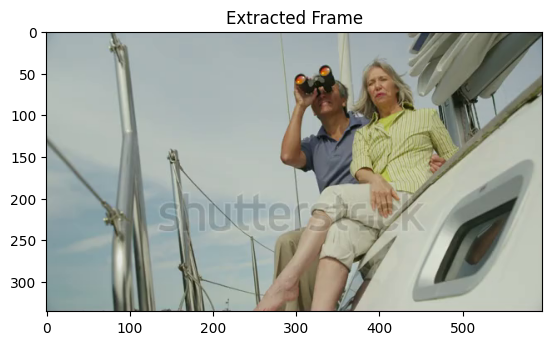

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(frames[0])
plt.title("Extracted Frame")
plt.show()


In [ ]:
import av
import numpy as np
import torch
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the trained model, processor, and tokenizer
model_path = "trained_model"
image_processor = AutoImageProcessor.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)

# Load video
video_path = "5629184.mp4"
container = av.open(video_path)

# Extract evenly spaced frames from video
seg_len = container.streams.video[0].frames
clip_len = model.config.encoder.num_frames
indices = set(np.linspace(0, seg_len, num=clip_len, endpoint=False).astype(np.int64))
frames = []
container.seek(0)
for i, frame in enumerate(container.decode(video=0)):
    if i in indices:
        frames.append(frame.to_ndarray(format="rgb24"))

# Debugging: Check frame shape
print(f"Number of frames extracted: {len(frames)}")
print(f"Shape of the first frame: {frames[0].shape}")

# Generate caption
gen_kwargs = {
    "min_length": 10,  # Increase the minimum length of the generated caption
    "max_length": 50,  # Increase the maximum length of the generated caption
    "num_beams": 5,    # Adjust the number of beams used for beam search
    "early_stopping": False,  # Stop generating when the end token is produced
}
pixel_values = image_processor(frames, return_tensors="pt").pixel_values.to(device)

# Debugging: Check pixel values shape
print(f"Shape of pixel values: {pixel_values.shape}")

tokens = model.generate(pixel_values, **gen_kwargs)
print(f"Generated tokens: {tokens}")

caption = tokenizer.batch_decode(tokens, skip_special_tokens=True)[0]
print(f"Generated caption: {caption}")


Number of frames extracted: 8
Shape of the first frame: (336, 596, 3)
Shape of pixel values: torch.Size([1, 8, 3, 224, 224])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1283: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Generated tokens: tensor([[50256,    13,   764,   764,   764,   764,   764,   764,   764,   764,
           764,   764,   764,   764,   764,   764,   764,   764,   764,   764,
           764,   764,   764,   764,   764,   764,   764,   764,   764,   764,
           764,   764,   764,   764,   764,   764,   764,   764,   764,   764,
           764,   764,   764,   764,   764,   764,   764,   764,   764,   764]],
       device='cuda:0')
Generated caption: .................................................
